## Read ME
* These codes are not finished yet. The simulation approaches gives very different results, so **THIS CODE IS NOT RELIABLE**.

* The code is incomplete because:
1. KDE estimtion needs cros-validation
2. Monte Carlo simulation robustness is not checked (i.e. interval estimation using bootstrapping)
3. Historical Approach lacks portfolio simulation.
4. Dependence Dependence is still immature.
5. There are some other methods that is not deployed yet.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from statsmodels.nonparametric.kde import KDEUnivariate  # For statsmodels KDE
from arch import arch_model
from scipy.stats import kstest
from fitter import Fitter
from scipy.stats import norm, t, skewnorm, uniform, lognorm, weibull_min, cauchy
from scipy.stats import rankdata, norm, t, kendalltau
from copulas.bivariate import Clayton, Gumbel
from sklearn.neighbors import KernelDensity  # For sklearn KDE
from scipy.stats import gaussian_kde
from Utils import homepath, compute_returns, WeightingScenario


import warnings
warnings.filterwarnings('ignore')

## Data

In [ ]:
stock_prices = pd.read_csv(homepath + 'data/stock_prices_30_tickers.csv',parse_dates=['Date'], index_col='Date')
rets = compute_returns(stock_prices)
returns_df = rets['weekly_log']
np.random.seed(42)
num_assets = returns_df.shape[1]
num_scenarios = 5
weighting_scenario_gen = WeightingScenario(num_assets=num_assets, num_scenarios=num_scenarios)
weighting_scenarios = weighting_scenario_gen.generate_weights()

## Descriptive Statistics

0.0013568171496839713


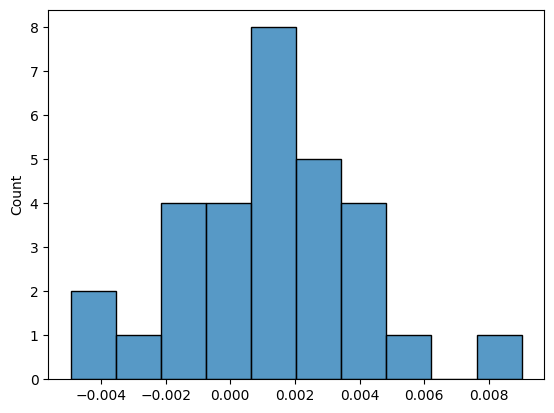

In [4]:
sns.histplot(
    rets['weekly_log'].mean(),
    bins=10
)

print(rets['weekly_log'].mean().mean())

<Axes: ylabel='Count'>

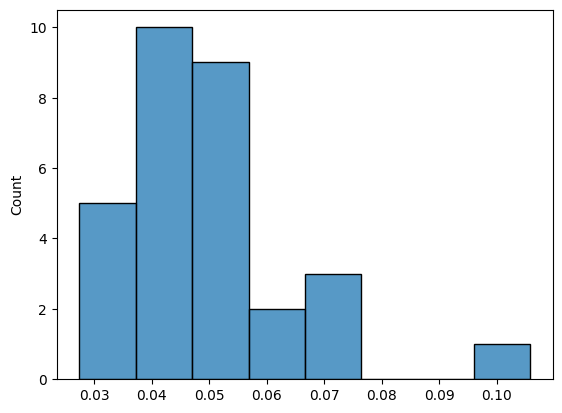

In [5]:
sns.histplot(
    rets['weekly_log'].std()
)

## Dependence Structure

### Pearson

In [6]:
corr_matrix = returns_df.corr()

### Copula (Guassian, t, Clayton, Gumbul)

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata, norm, t
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from copulas.bivariate import Clayton, Gumbel

# Step 1: Winsorizer class for outlier handling
class Winsorizer(BaseEstimator, TransformerMixin):
    """Winsorize data to reduce outlier effects."""
    
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if isinstance(X, pd.DataFrame):  # Ensure `X` is a pandas DataFrame for compatibility
            for col in X.columns:
                lower = X[col].quantile(self.lower_quantile)
                upper = X[col].quantile(self.upper_quantile)
                X[col] = np.clip(X[col], lower, upper)
        else:
            raise ValueError("Input to Winsorizer must be a pandas DataFrame.")
        return X

# Step 2: CopulaCorrelation class for computing copula-based correlations
class CopulaCorrelation(BaseEstimator, TransformerMixin):
    """Compute correlation matrix using Gaussian, t, and Archimedean copulas."""
    
    def __init__(self, method='gaussian', dof=10):
        self.method = method
        self.dof = dof  # Degrees of freedom for t-Copula
        self.correlation_matrix = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()  # Convert DataFrame to numpy array for processing

        # Step 2.1: Transform data to uniform marginals [0, 1]
        ranked_data = np.apply_along_axis(rankdata, axis=0, arr=X)
        u = (ranked_data - 0.5) / len(X)  # Convert to U(0, 1)

        # Step 2.2: Handle different copula types
        if self.method.lower() == 'gaussian':
            norm_quantiles = norm.ppf(u)
            self.correlation_matrix = np.corrcoef(norm_quantiles.T)
        
        elif self.method.lower() == 't':
            t_quantiles = t.ppf(u, df=self.dof)
            self.correlation_matrix = np.corrcoef(t_quantiles.T)

        elif self.method.lower() in ['clayton', 'gumbel']:
            # Use Archimedean Copulas (Clayton or Gumbel)
            print(f"Computing correlation matrix using {self.method.capitalize()} copula.")
            if self.method.lower() == 'clayton':
                copula = Clayton()
            elif self.method.lower() == 'gumbel':
                copula = Gumbel()

            # Fit copulas to each pair of variables
            n_assets = X.shape[1]
            copula_correlation = np.zeros((n_assets, n_assets))

            for i in range(n_assets):
                for j in range(i + 1, n_assets):
                    # Handle invalid theta values and edge cases
                    try:
                        pairwise_data = np.column_stack((u[:, i], u[:, j]))
                        copula.fit(pairwise_data)  # Attempt to fit the copula
                        theta = copula.theta
                        if np.isnan(theta) or theta == 0.0:  # Check for invalid thetas
                            raise ValueError(f"Invalid theta: {theta}")
                        copula_correlation[i, j] = theta  # Store the copula parameter
                        copula_correlation[j, i] = theta  # Symmetry
                    except ValueError as e:
                        print(f"Error fitting copula for pair ({i}, {j}): {e}")
                        copula_correlation[i, j] = np.nan
                        copula_correlation[j, i] = np.nan
            
            # Assign the correlation matrix
            self.correlation_matrix = copula_correlation
        
        else:
            raise ValueError(f"Unsupported copula method: {self.method}")

        return self

    def transform(self, X):
        if self.correlation_matrix is None:
            raise RuntimeError("Fit the transformer before calling transform.")
        return self.correlation_matrix

# Step 3: Create a pipeline for correlation matrix computations
def create_pipeline(copula_method='gaussian', dof=10):
    """Create a pipeline that computes the correlation matrix using the chosen copula."""
    return Pipeline([
        ("winsorizer", Winsorizer(lower_quantile=0.05, upper_quantile=0.95)),
        ("copula_correlation", CopulaCorrelation(method=copula_method, dof=dof)),
    ])

# Step 4: Test the pipeline and return a dictionary of correlation matrices
def get_correlation_matrices(data, methods=['gaussian', 't', 'clayton', 'gumbel'], dof=10):
    """
    Compute correlation matrices for multiple copula methods and return a dictionary.
    
    Parameters:
        - data (pd.DataFrame): The dataset to compute correlations on.
        - methods (list): List of copula methods to use (default=['gaussian', 't', 'clayton', 'gumbel']).
        - dof (int): Degrees of freedom for t-Copula (default=10).
    
    Returns:
        - dict: A dictionary with copula methods as keys and correlation matrices as values.
    """
    correlation_matrices = {}
    
    for method in methods:
        pipeline = create_pipeline(copula_method=method, dof=dof)
        correlation_matrix = pipeline.fit_transform(data)
        correlation_matrices[method.capitalize()] = pd.DataFrame(
            correlation_matrix, columns=data.columns, index=data.columns
        )
    
    return correlation_matrices

# Main block to test the function
if __name__ == "__main__":

    data = returns_df
    correlation_matrices = get_correlation_matrices(data)

Computing correlation matrix using Clayton copula.
Error fitting copula for pair (22, 29): The computed theta value -0.0016188499746831835 is out of limits for the given CLAYTON copula.
Computing correlation matrix using Gumbel copula.
Error fitting copula for pair (22, 29): The computed theta value 0.9991905750126584 is out of limits for the given GUMBEL copula.


## Historical Simulation

### Bootstrap with implicit correlation matrice
* The block bootstrap method implicitly considers the dependence structure.

Running scenario: 0
Running scenario: 1
Running scenario: 2
Running scenario: 3
Running scenario: 4

Risk Metrics for Different Weighting Scenarios:
     Scenario  Expected Return   VaR 90%   VaR 95%   VaR 99%  CVaR 90%  \
0  Scenario_1        -0.000034 -0.000188 -0.000230 -0.000310 -0.000243   
1  Scenario_2         0.000026 -0.000128 -0.000170 -0.000257 -0.000186   
2  Scenario_3        -0.000018 -0.000126 -0.000158 -0.000212 -0.000166   
3  Scenario_4        -0.000102 -0.000247 -0.000287 -0.000364 -0.000300   
4  Scenario_5         0.000080 -0.000012 -0.000038 -0.000088 -0.000046   

   CVaR 95%  CVaR 99%  
0 -0.000280 -0.000350  
1 -0.000225 -0.000310  
2 -0.000191 -0.000240  
3 -0.000335 -0.000409  
4 -0.000068 -0.000112  
Results saved to 'risk_metrics.csv'


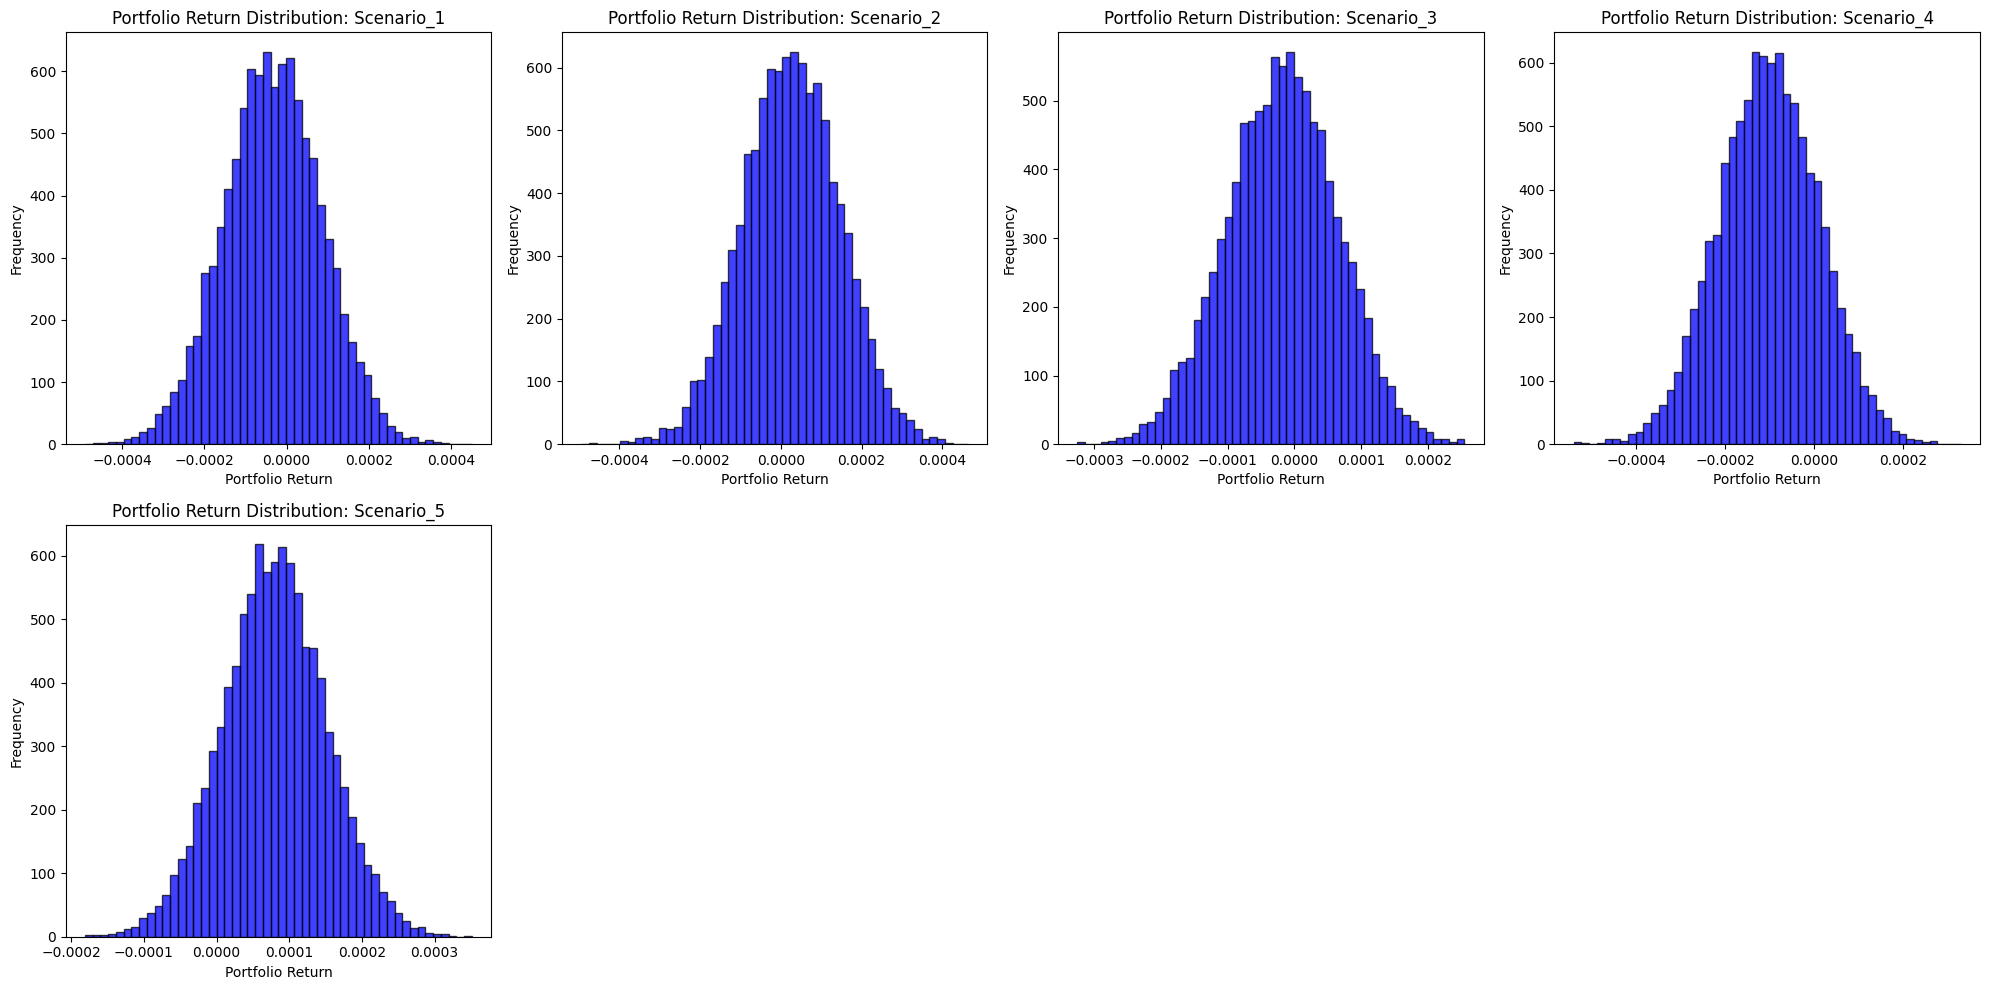

In [13]:
tickers = returns_df.columns


# Step 2: Create Winsorizer transformer
class Winsorizer(BaseEstimator, TransformerMixin):
    """Transformer to apply winsorization to limit outliers."""

    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Apply winsorization to each column in the DataFrame."""
        X = X.copy()
        for col in X.columns:
            lower_bound = np.quantile(X[col], self.lower_quantile)
            upper_bound = np.quantile(X[col], self.upper_quantile)
            X[col] = np.clip(X[col], lower_bound, upper_bound)
        return X


# Step 3: Create GARCHSimulator transformer
class GARCHSimulator(BaseEstimator, TransformerMixin):
    """Fits a GARCH model to each ticker's returns and simulates future returns."""

    def __init__(self, n_simulations=10000, p=1, q=1):
        self.n_simulations = n_simulations
        self.p = p  # GARCH(p, q): order of AR process
        self.q = q  # GARCH(p, q): order of MA process

    def fit(self, X, y=None):
        self.garch_models = {}

        for col in X.columns:
            model = arch_model(X[col], vol="Garch", p=self.p, q=self.q)
            garch_fit = model.fit(disp="off")

            # Store the fitted model
            self.garch_models[col] = garch_fit

        return self

    def transform(self, X):
        simulated_returns = np.zeros((self.n_simulations, X.shape[1]))

        for i, col in enumerate(X.columns):
            garch_fit = self.garch_models[col]
            resids = np.random.normal(0, garch_fit.conditional_volatility[-1], self.n_simulations)
            simulated_returns[:, i] = resids

        return pd.DataFrame(simulated_returns, columns=X.columns)


# Step 4: Create BlockBootstrapper transformer
class BlockBootstrapper(BaseEstimator, TransformerMixin):
    """Performs block bootstrapping to preserve time-series structure and applies weighting."""

    def __init__(self, block_size=5, n_simulations=10000, weights=None):
        self.block_size = block_size
        self.n_simulations = n_simulations
        self.weights = weights  # Weights are passed during initialization

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.weights is None:
            raise ValueError("Weights must be provided during initialization.")

        n_obs, n_assets = X.shape
        blocks = [X.values[i:i + self.block_size] for i in range(n_obs - self.block_size + 1)]
        portfolio_returns = np.empty(self.n_simulations)

        for i in range(self.n_simulations):
            sampled_indices = np.random.randint(0, len(blocks), size=n_obs // self.block_size + 1)
            sampled_blocks = [blocks[idx] for idx in sampled_indices]
            sampled_data = np.vstack(sampled_blocks)[:n_obs]
            portfolio_returns[i] = sampled_data.dot(self.weights).mean()

        return portfolio_returns


# Step 5: Create the pipeline
def create_pipeline(weights):
    return Pipeline([
        ("winsorizer", Winsorizer(lower_quantile=0.05, upper_quantile=0.95)),
        ("garch_simulator", GARCHSimulator(n_simulations=10000)),
        ("block_bootstrapper", BlockBootstrapper(block_size=5, n_simulations=10000, weights=weights)),
    ])


# Step 6: Weights
weighting_scenario_gen = WeightingScenario(num_assets=num_assets, custom_weights=weighting_scenarios)
weighting_scenarios = weighting_scenario_gen.generate_weights()

# Step 7: Prepare to store results
results = []
simulated_data = {}

# Step 8: Iterate through each weighting scenario
for i, weights in enumerate(weighting_scenarios):
    print(f"Running scenario: {i}")
    scenario_name = f"Scenario_{i + 1}"

    # Create pipeline for this scenario
    pipeline = create_pipeline(weights)

    # Fit and transform the pipeline on the returns data
    simulated_portfolio_returns = pipeline.fit_transform(returns_df)

    # Save simulated data for plotting
    simulated_data[scenario_name] = simulated_portfolio_returns

    # Step 9: Calculate risk metrics
    mean_return = np.mean(simulated_portfolio_returns)
    var_90 = np.percentile(simulated_portfolio_returns, 10)
    var_95 = np.percentile(simulated_portfolio_returns, 5)
    var_99 = np.percentile(simulated_portfolio_returns, 1)

    cvar_90 = simulated_portfolio_returns[simulated_portfolio_returns <= var_90].mean()
    cvar_95 = simulated_portfolio_returns[simulated_portfolio_returns <= var_95].mean()
    cvar_99 = simulated_portfolio_returns[simulated_portfolio_returns <= var_99].mean()

    # Step 10: Store the results
    results.append({
        "Scenario": scenario_name,
        "Expected Return": mean_return,
        "VaR 90%": var_90,
        "VaR 95%": var_95,
        "VaR 99%": var_99,
        "CVaR 90%": cvar_90,
        "CVaR 95%": cvar_95,
        "CVaR 99%": cvar_99,
    })

# Step 11: Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nRisk Metrics for Different Weighting Scenarios:")
print(results_df)

# Optional: Save results to CSV
results_df.to_csv(homepath + "data/risk_metrics.csv", index=False)
print("Results saved to 'risk_metrics.csv'")

# Step 12: Plot histograms of portfolio returns for all scenarios

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # 2 rows and up to 4 columns
axes = axes.flatten()  # Flatten the axes array for easier indexing

scenarios_to_plot = list(simulated_data.keys())[:7]  # Select up to the first 7 scenarios, if available
for i, scenario in enumerate(scenarios_to_plot):
    ax = axes[i]
    ax.hist(simulated_data[scenario], bins=50, alpha=0.75, color="blue", edgecolor="black")
    ax.set_title(f"Portfolio Return Distribution: {scenario}")
    ax.set_xlabel("Portfolio Return")
    ax.set_ylabel("Frequency")

# Hide any unused subplots if fewer than 8 scenarios exist
for j in range(len(scenarios_to_plot), len(axes)):
    fig.delaxes(axes[j])  # Remove unused subplot areas

plt.tight_layout()
plt.show()


### Bootstrap with Explicit Correlation Matrix
* The simple correlation matrix is used in order to capture the effect of introducing the correlaiton matrix to the model explicitly. In a separate file correlation matrix is separately estimated.

In [14]:

# Step 1: Get tickers (columns of returns DataFrame)
tickers = returns_df.columns

# Step 2: Create a Winsorizer - No changes here
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            lower_bound = np.quantile(X[col], self.lower_quantile)
            upper_bound = np.quantile(X[col], self.upper_quantile)
            X[col] = np.clip(X[col], lower_bound, upper_bound)
        return X

# Step 3: Update the GARCHSimulator to use the correlation matrix
class GARCHSimulator(BaseEstimator, TransformerMixin):
    def __init__(self, n_simulations=10000, p=1, q=1, correlation_matrix=None):
        self.n_simulations = n_simulations
        self.p = p
        self.q = q
        self.correlation_matrix = correlation_matrix  # New: Correlation Matrix

    def fit(self, X, y=None):
        self.garch_models = {}

        # Step 3.1: Fit GARCH models for each asset
        for col in X.columns:
            model = arch_model(X[col], vol="Garch", p=self.p, q=self.q)
            garch_fit = model.fit(disp="off")
            self.garch_models[col] = garch_fit

        return self

    def transform(self, X):
        # Step 3.2: Generate independent simulations for each asset
        simulated_independent = np.zeros((self.n_simulations, len(X.columns)))

        for i, col in enumerate(X.columns):
            garch_fit = self.garch_models[col]
            volatility = garch_fit.conditional_volatility[-1]
            simulated_independent[:, i] = np.random.normal(
                loc=0, scale=volatility, size=self.n_simulations
            )

        # Step 3.3: Introduce correlation using the provided matrix
        # Apply Cholesky decomposition to induce correlation
        if self.correlation_matrix is not None:
            L = np.linalg.cholesky(self.correlation_matrix)
            simulated_dependent = simulated_independent @ L.T
        else:
            simulated_dependent = simulated_independent

        return pd.DataFrame(simulated_dependent, columns=X.columns)

# Step 4: Update Block Bootstrapper if needed (no correlation impact here)
class BlockBootstrapper(BaseEstimator, TransformerMixin):
    def __init__(self, block_size=5, n_simulations=10000, weights=None):
        self.block_size = block_size
        self.n_simulations = n_simulations
        self.weights = weights

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.weights is None:
            raise ValueError("Weights must be provided during initialization.")

        n_obs, n_assets = X.shape
        blocks = [X.values[i:i + self.block_size] for i in range(n_obs - self.block_size + 1)]
        portfolio_returns = np.empty(self.n_simulations)

        for i in range(self.n_simulations):
            sampled_indices = np.random.randint(0, len(blocks), size=n_obs // self.block_size + 1)
            sampled_blocks = [blocks[idx] for idx in sampled_indices]
            sampled_data = np.vstack(sampled_blocks)[:n_obs]
            portfolio_returns[i] = sampled_data.dot(self.weights).mean()

        return portfolio_returns

# Step 5: Create the pipeline
def create_pipeline(weights, correlation_matrix):
    return Pipeline([
        ("winsorizer", Winsorizer(lower_quantile=0.05, upper_quantile=0.95)),
        ("garch_simulator", GARCHSimulator(n_simulations=10000, correlation_matrix=correlation_matrix)),
        ("block_bootstrapper", BlockBootstrapper(block_size=5, n_simulations=10000, weights=weights)),
    ])

# Step 6: Generate or load a correlation matrix
# Compute the correlation matrix from the returns data (or load an external one)
correlation_matrix = corr_matrix

# Step 7: Continue as before
weighting_scenario_gen = WeightingScenario(num_assets=num_assets, custom_weights=weighting_scenarios)
weighting_scenarios = weighting_scenario_gen.generate_weights()

results = []
simulated_data = {}

# Iterate through each weighting scenario
for i, weights in enumerate(weighting_scenarios):
    print(f"Running scenario: {i}")
    scenario_name = f"Scenario_{i + 1}"

    # Create pipeline for this scenario
    pipeline = create_pipeline(weights, correlation_matrix)

    # Fit and transform the pipeline on the returns data
    simulated_portfolio_returns = pipeline.fit_transform(returns_df)

    # Save simulated data for plotting
    simulated_data[scenario_name] = simulated_portfolio_returns

    # Step 9: Calculate risk metrics
    mean_return = np.mean(simulated_portfolio_returns)
    var_90 = np.percentile(simulated_portfolio_returns, 10)
    var_95 = np.percentile(simulated_portfolio_returns, 5)
    var_99 = np.percentile(simulated_portfolio_returns, 1)

    cvar_90 = simulated_portfolio_returns[simulated_portfolio_returns <= var_90].mean()
    cvar_95 = simulated_portfolio_returns[simulated_portfolio_returns <= var_95].mean()
    cvar_99 = simulated_portfolio_returns[simulated_portfolio_returns <= var_99].mean()

    # Store the results
    results.append({
        "Scenario": scenario_name,
        "Expected Return": mean_return,
        "VaR 90%": var_90,
        "VaR 95%": var_95,
        "VaR 99%": var_99,
        "CVaR 90%": cvar_90,
        "CVaR 95%": cvar_95,
        "CVaR 99%": cvar_99,
    })

# Step 10: Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nRisk Metrics for Different Weighting Scenarios:")
print(results_df)

# Optional: Save results to CSV
results_df.to_csv(homepath + "data/risk_metrics.csv", index=False)
print("Results saved to 'risk_metrics.csv'")


Running scenario: 0
Running scenario: 1
Running scenario: 2
Running scenario: 3
Running scenario: 4

Risk Metrics for Different Weighting Scenarios:
     Scenario  Expected Return   VaR 90%   VaR 95%   VaR 99%  CVaR 90%  \
0  Scenario_1         0.000147 -0.000208 -0.000310 -0.000495 -0.000341   
1  Scenario_2        -0.000177 -0.000539 -0.000647 -0.000848 -0.000680   
2  Scenario_3        -0.000300 -0.000645 -0.000746 -0.000945 -0.000779   
3  Scenario_4        -0.000051 -0.000392 -0.000494 -0.000684 -0.000524   
4  Scenario_5        -0.000456 -0.000804 -0.000900 -0.001086 -0.000930   

   CVaR 95%  CVaR 99%  
0 -0.000426 -0.000595  
1 -0.000770 -0.000937  
2 -0.000866 -0.001041  
3 -0.000609 -0.000772  
4 -0.001013 -0.001186  
Results saved to 'risk_metrics.csv'


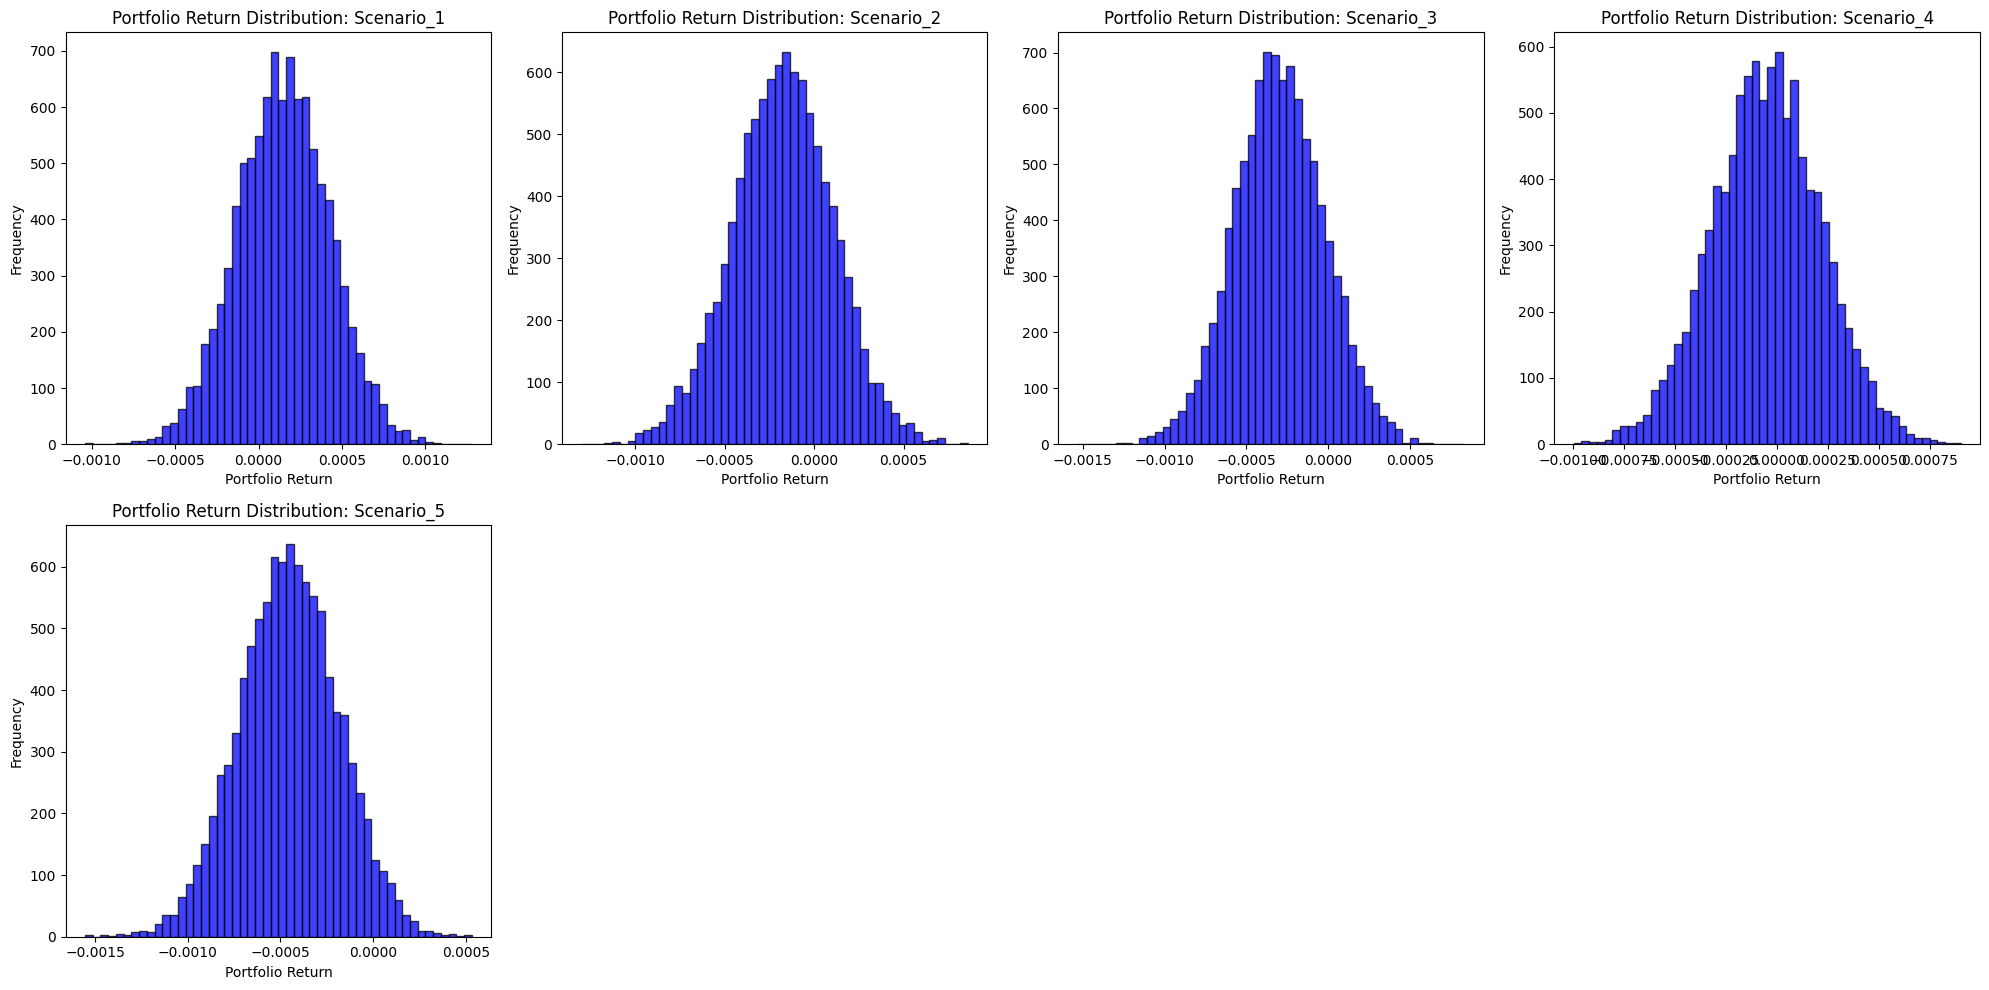

In [15]:
# Step 12: Plot histograms of portfolio returns for all scenarios

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # 2 rows and up to 4 columns
axes = axes.flatten()  # Flatten the axes array for easier indexing

scenarios_to_plot = list(simulated_data.keys())[:7]  # Select up to the first 7 scenarios, if available
for i, scenario in enumerate(scenarios_to_plot):
    ax = axes[i]
    ax.hist(simulated_data[scenario], bins=50, alpha=0.75, color="blue", edgecolor="black")
    ax.set_title(f"Portfolio Return Distribution: {scenario}")
    ax.set_xlabel("Portfolio Return")
    ax.set_ylabel("Frequency")

# Hide any unused subplots if fewer than 8 scenarios exist
for j in range(len(scenarios_to_plot), len(axes)):
    fig.delaxes(axes[j])  # Remove unused subplot areas

plt.tight_layout()
plt.show()


## Monte Carlo

### Density Estimation (Fitter package)

#### Estimation

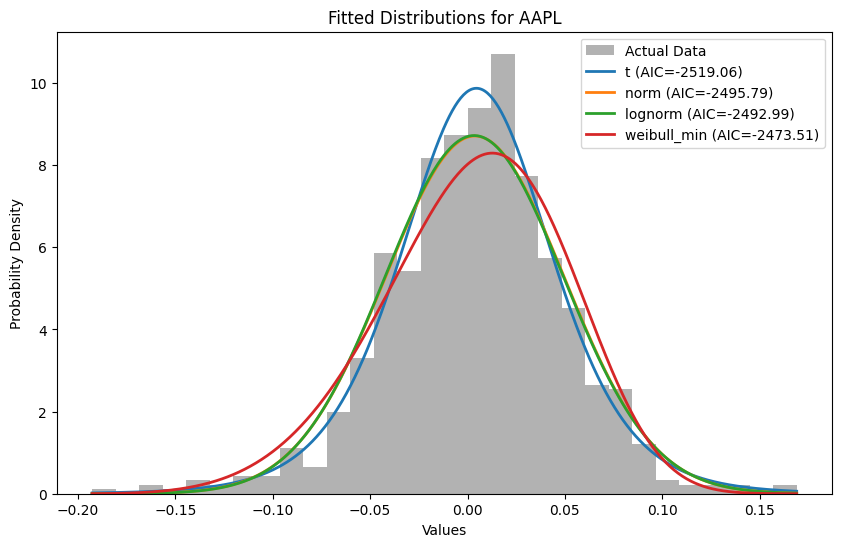

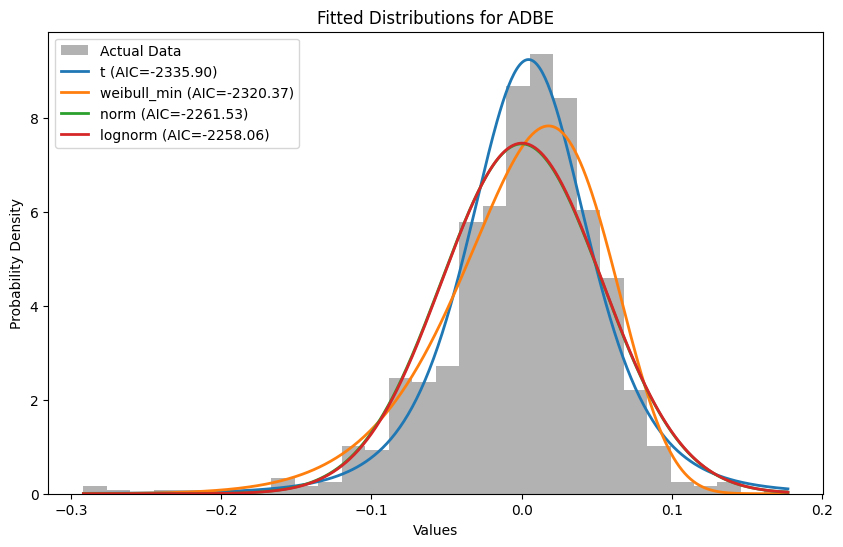

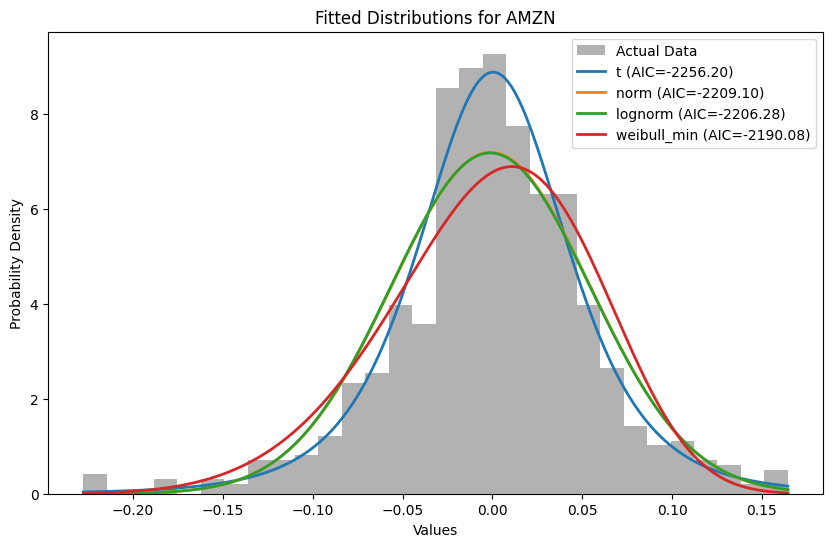

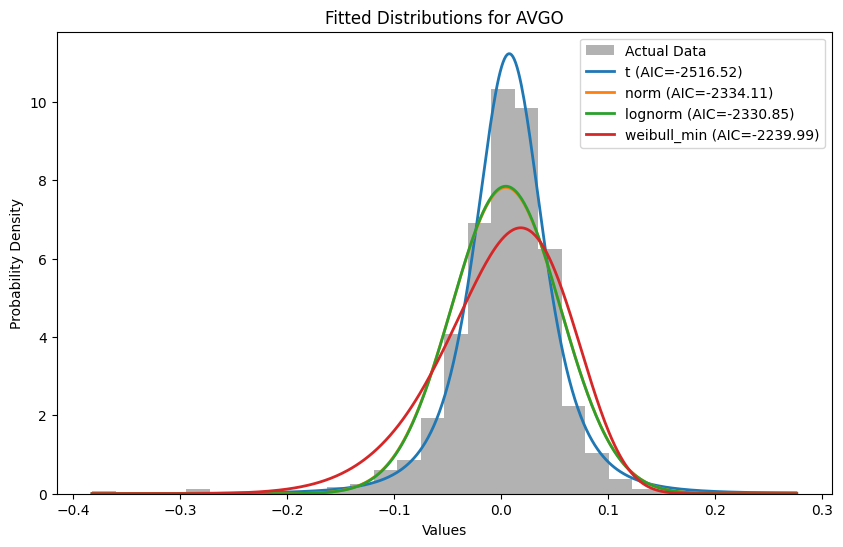

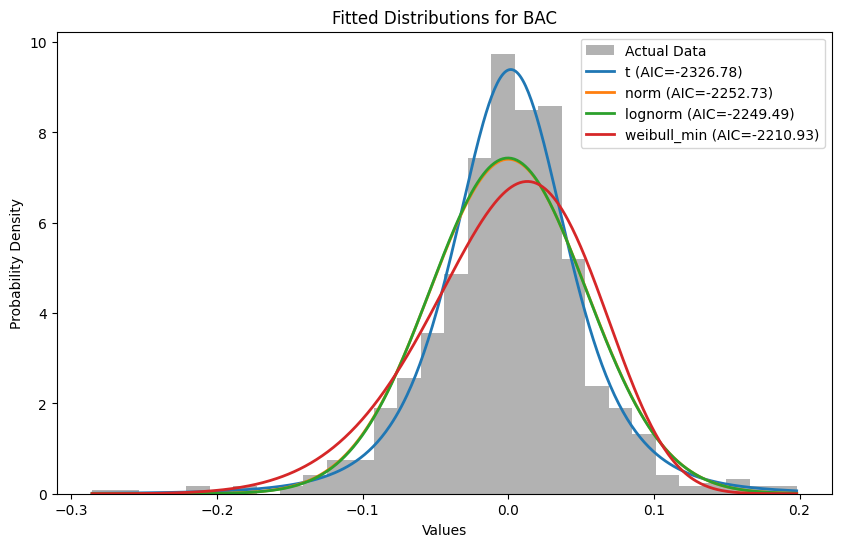

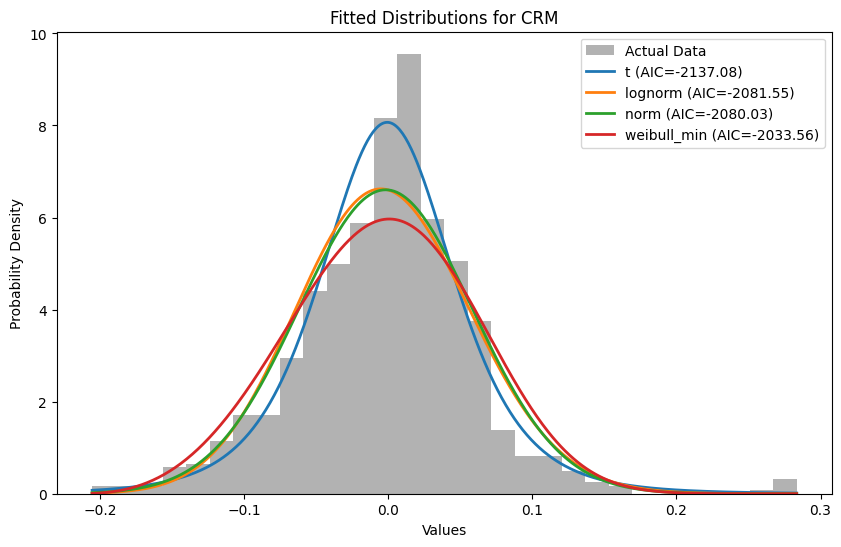

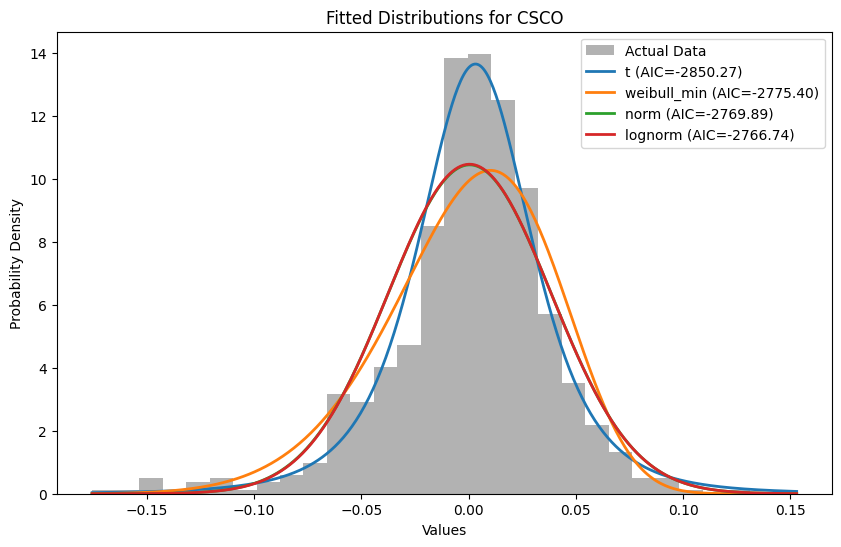

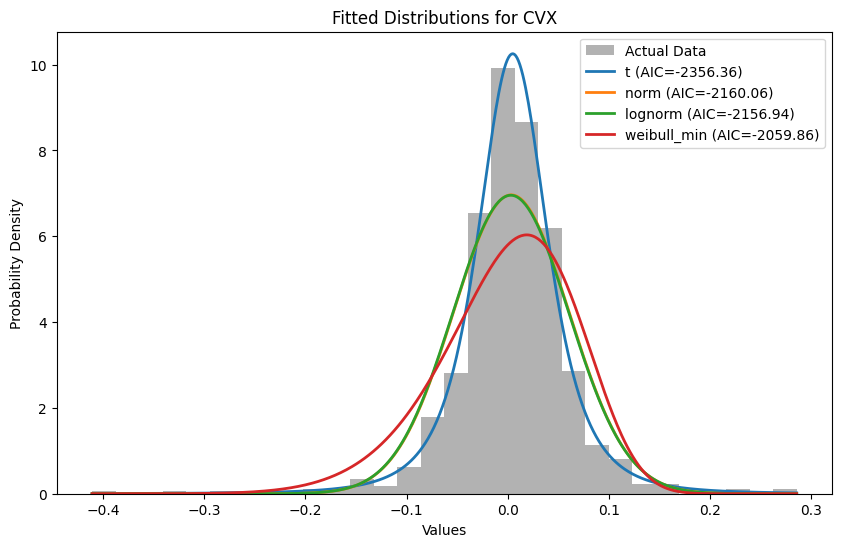

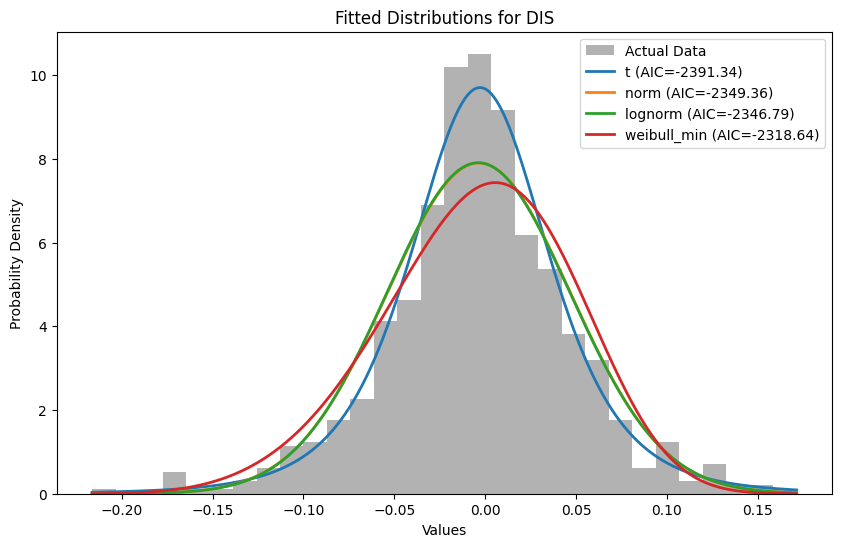

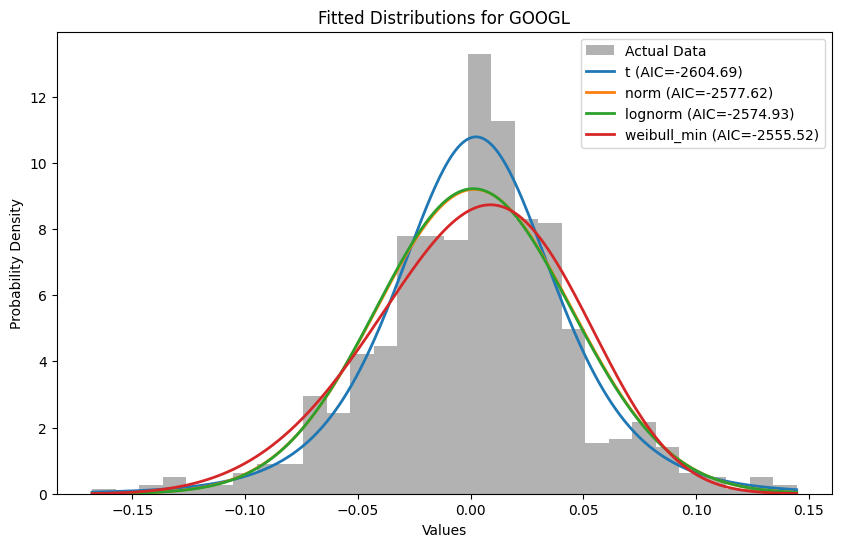

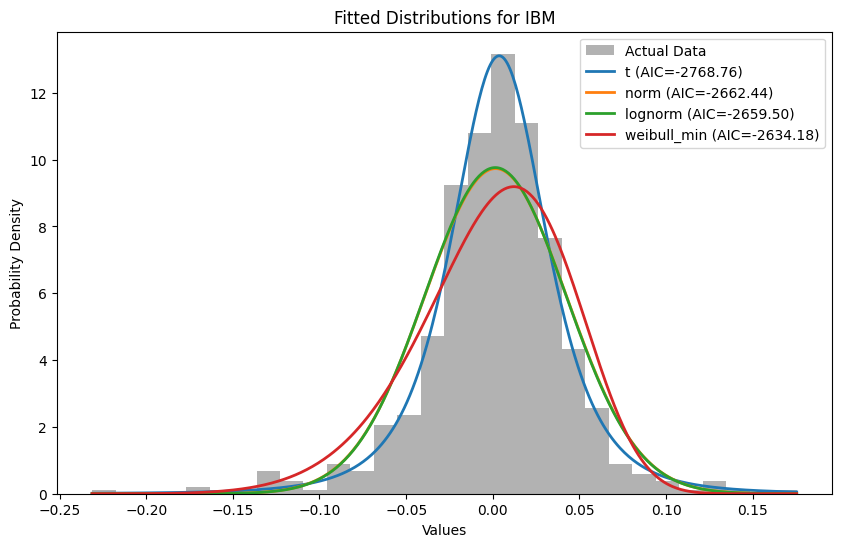

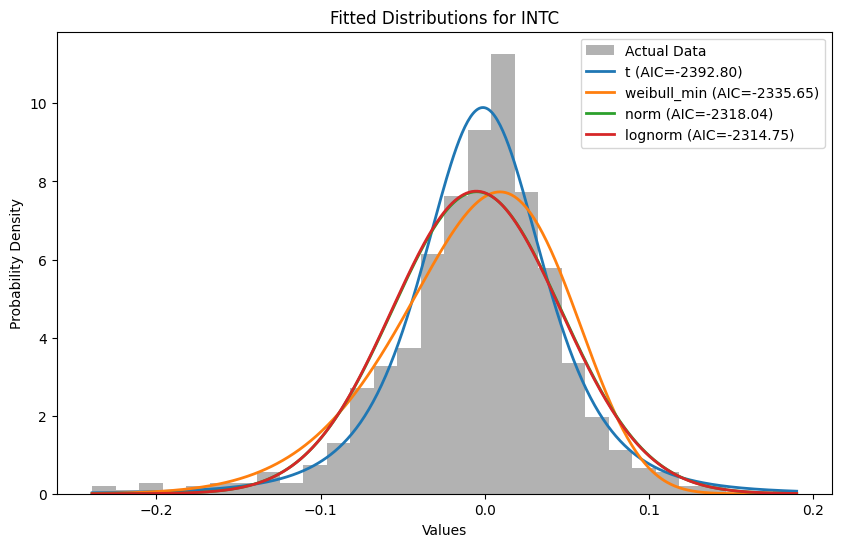

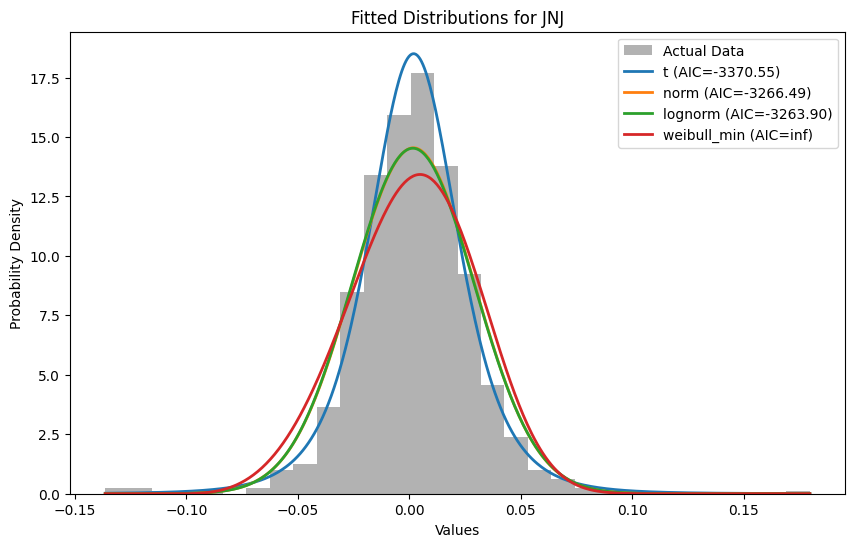

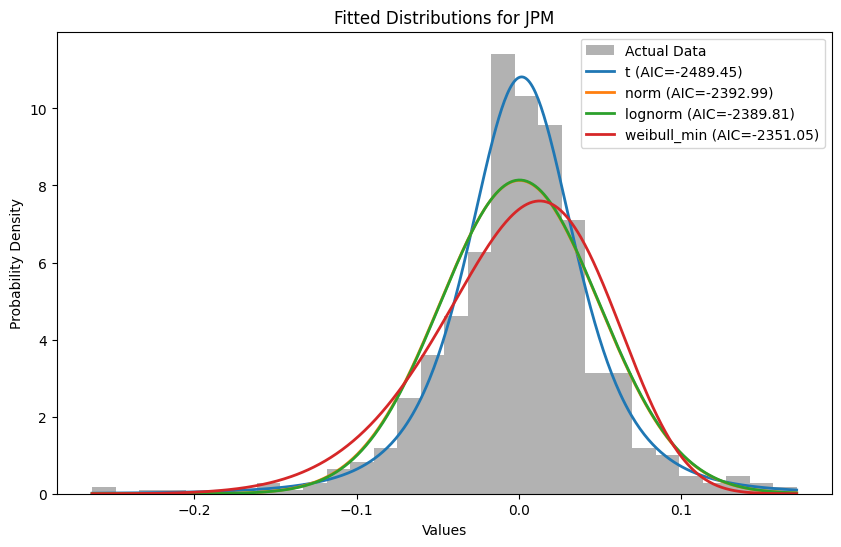

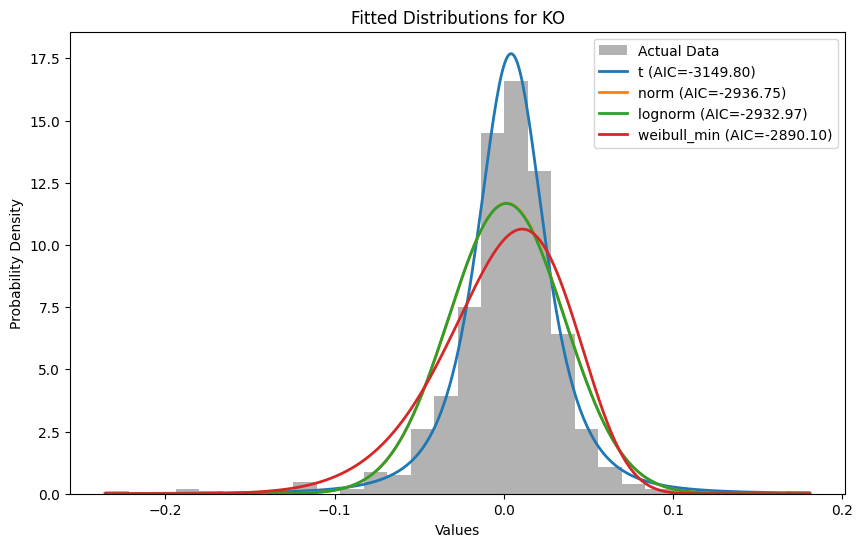

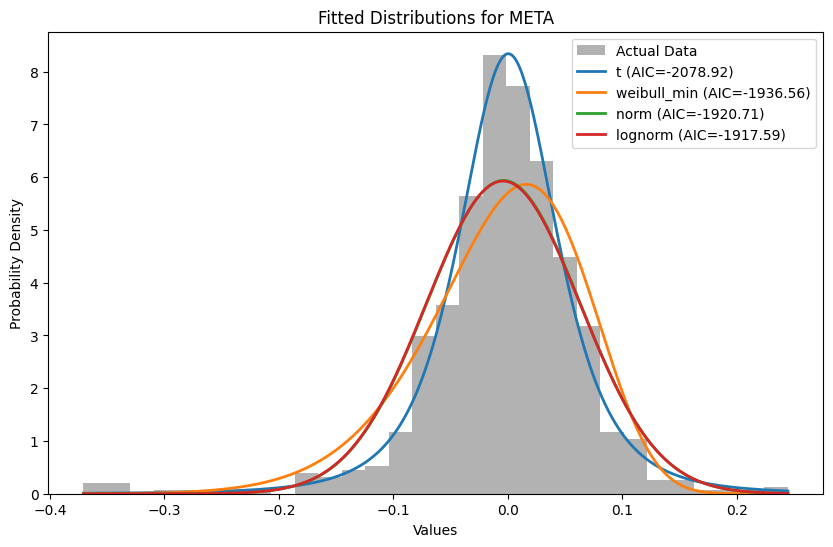

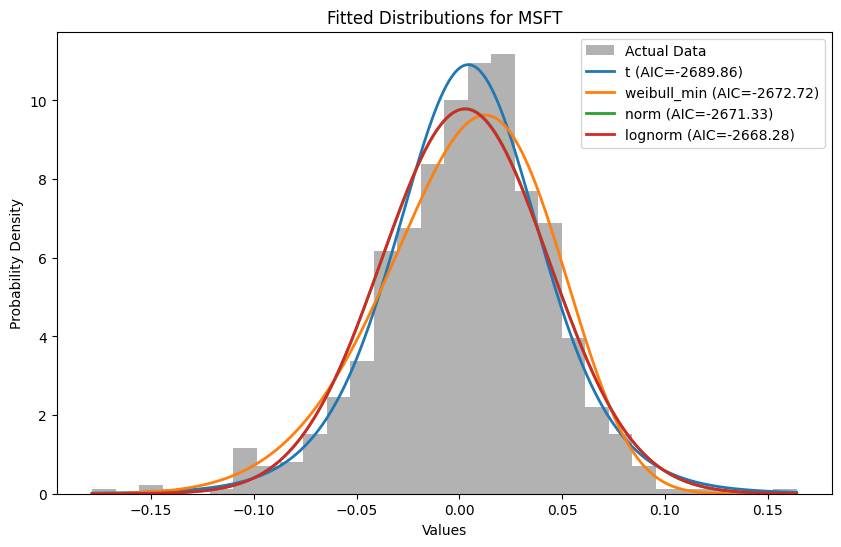

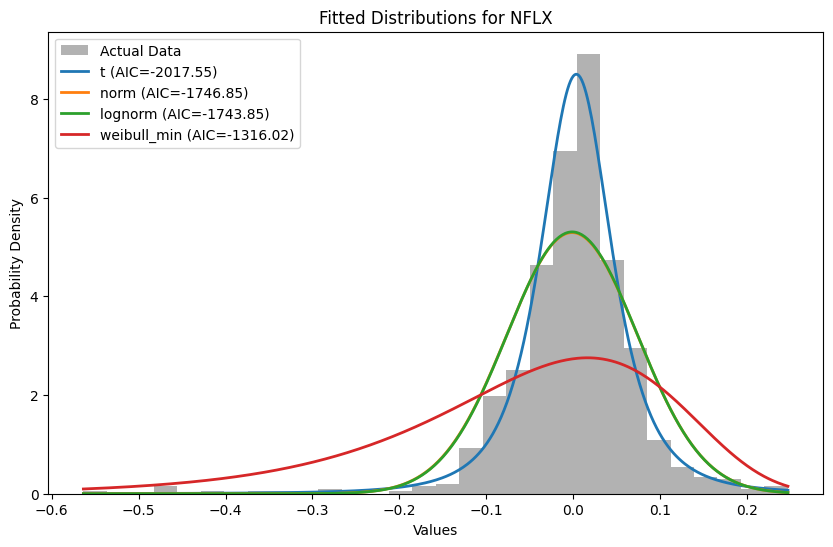

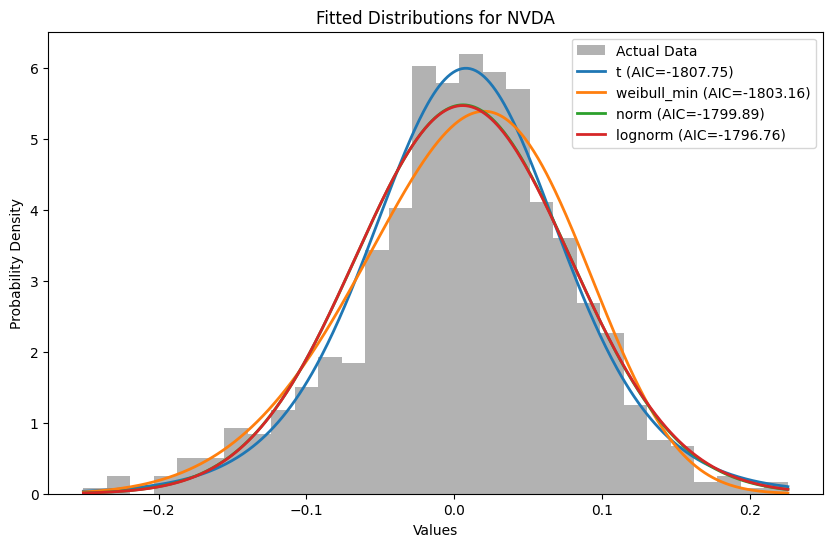

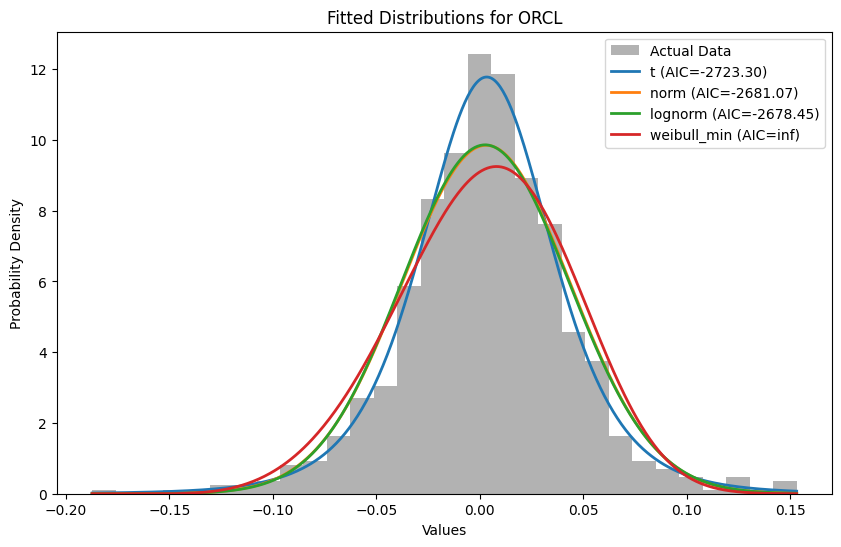

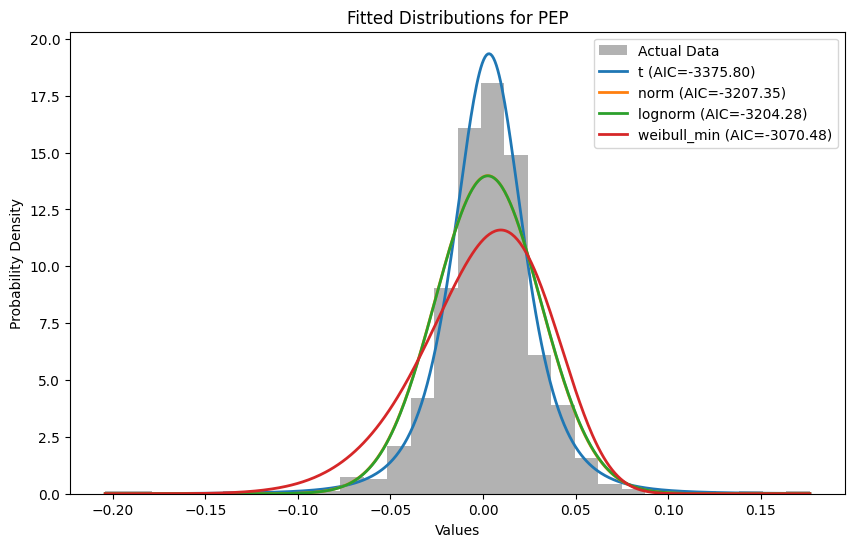

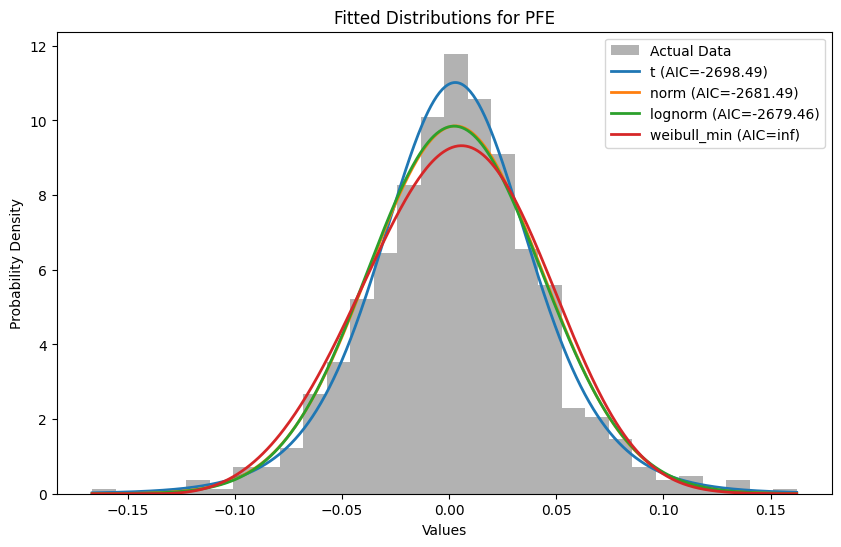

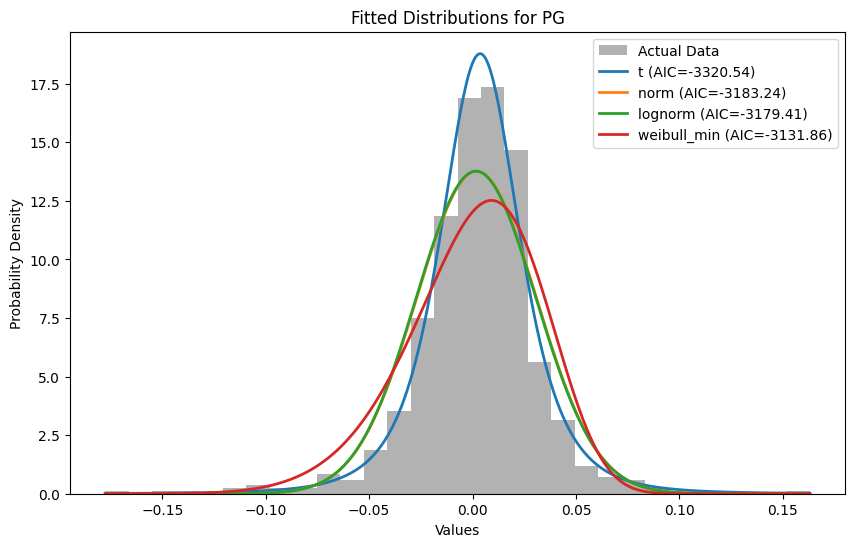

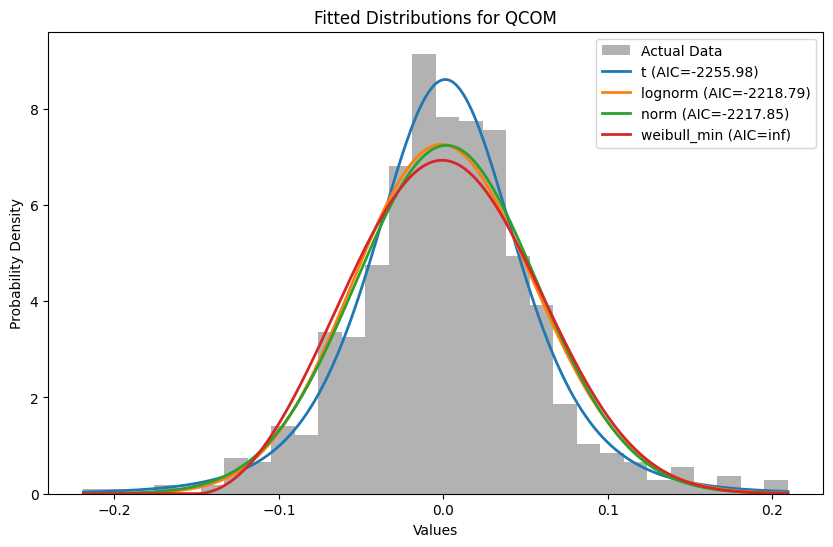

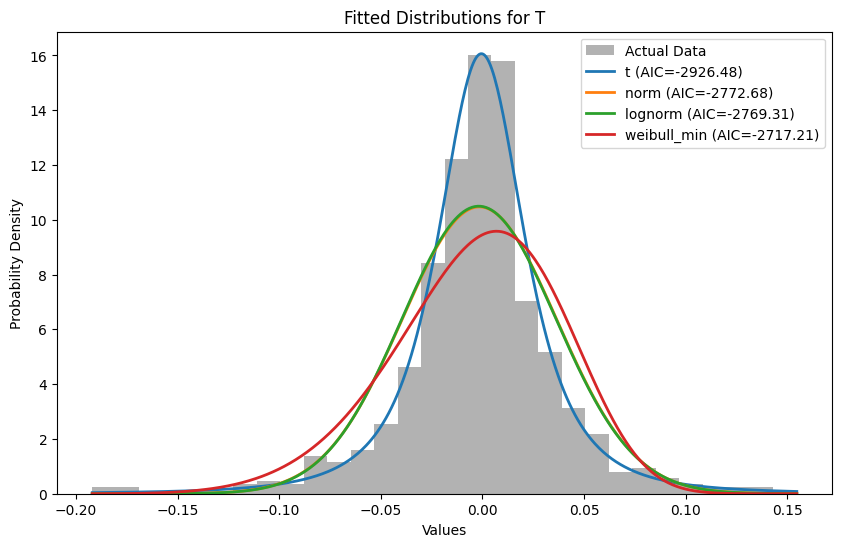

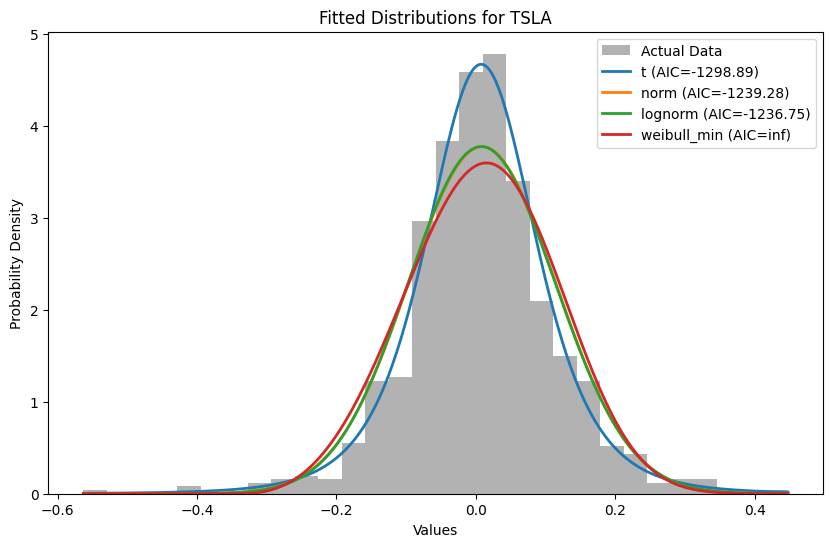

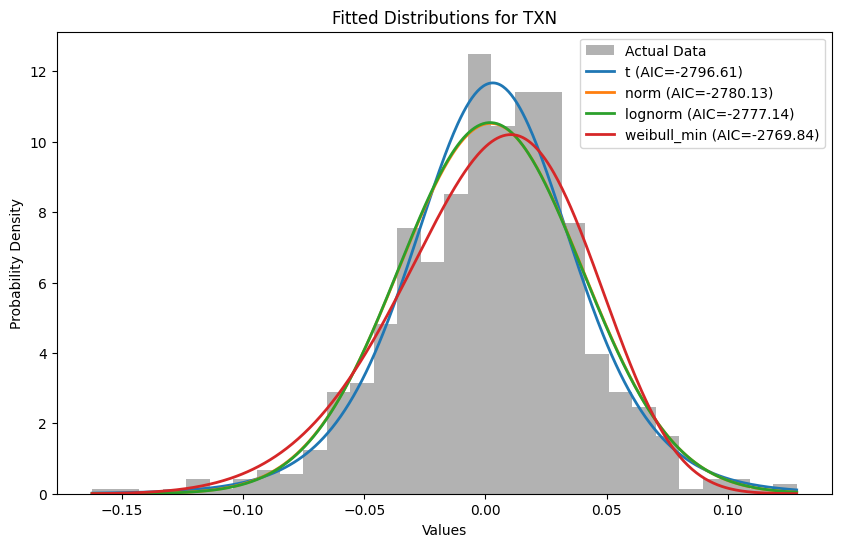

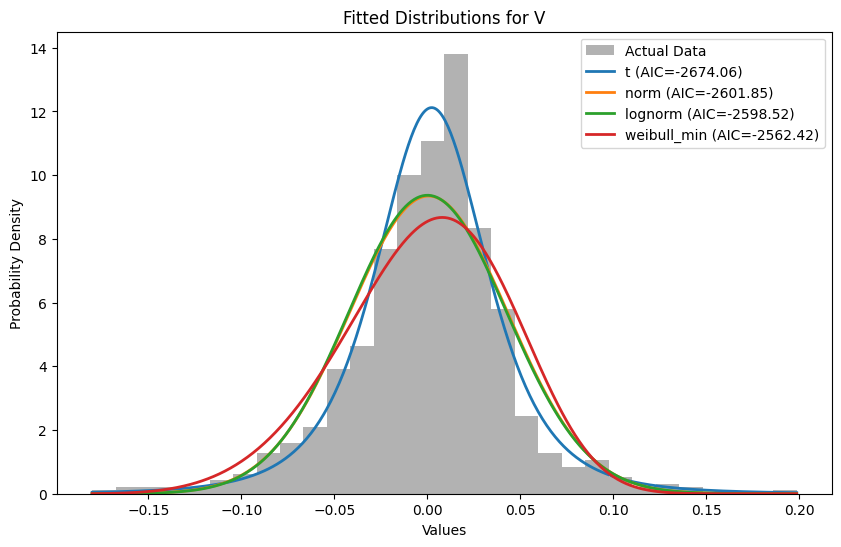

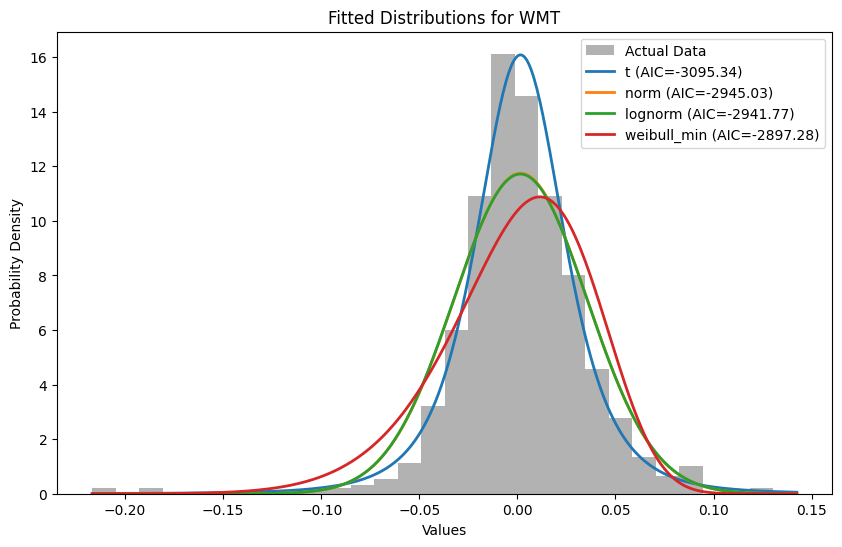

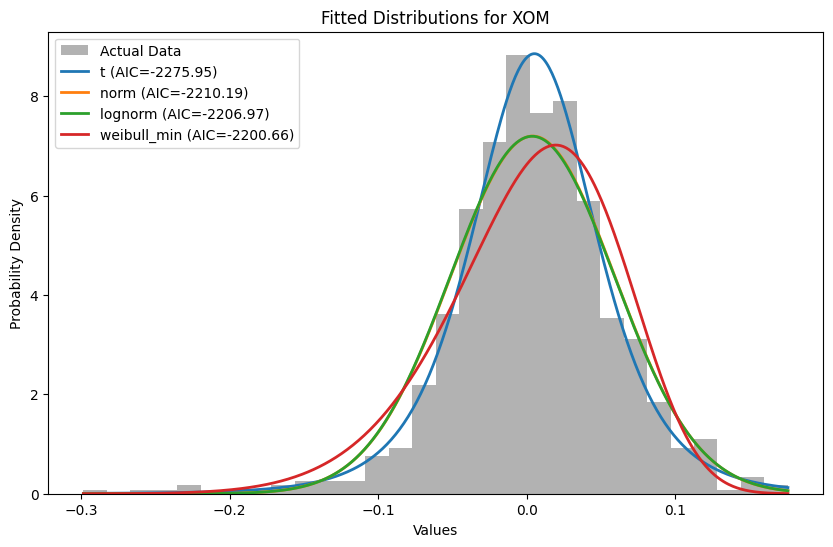

In [16]:
# 1. Distribution Evaluation Class
class DistributionEvaluatorWithFitter:
    def __init__(self):
        self.fitter_results = {}

    def fit(self, X, y=None):
        """
        Use the fitter library to fit common distributions and store results,
        excluding the 'chi2' distribution.
        """
        # Ensure X is a pandas DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input to DistributionEvaluatorWithFitter must be a pandas DataFrame.")
        
        self.fitter_results = {}
        # Exclude 'chi2' from the list of common distributions
        common_distributions = ['lognorm', 'norm', 'weibull_min', 't']
        
        for column in X.columns:
            f = Fitter(X[column], distributions=common_distributions)
            f.fit()
            self.fitter_results[column] = f
        return self

    def transform(self, X):
        """
        Evaluate fitted distributions using the Kolmogorov-Smirnov test and sort results by AIC.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input to DistributionEvaluatorWithFitter must be a pandas DataFrame.")
        
        evaluation_results = {}

        for column, fitter_obj in self.fitter_results.items():
            metrics = []

            for dist_name, params in fitter_obj.fitted_param.items():
                try:
                    # Retrieve the corresponding distribution PDF and CDF
                    dist = getattr(__import__('scipy.stats', fromlist=[dist_name]), dist_name)

                    # CDF for KS test
                    cdf = lambda v, dist=dist, params=params: dist.cdf(v, *params)
                    
                    # Apply KS test
                    ks_stat, ks_p_value = kstest(X[column], cdf)
                    
                    # Calculate AIC and BIC
                    n = len(X[column])
                    num_params = len(params)
                    log_likelihood = np.sum(dist.logpdf(X[column], *params))
                    aic = 2 * num_params - 2 * log_likelihood
                    bic = np.log(n) * num_params - 2 * log_likelihood

                    # Append metrics
                    metrics.append({
                        'Distribution': dist_name,
                        'AIC': aic,
                        'BIC': bic,
                        'KS Statistic': ks_stat,
                        'KS p-value': ks_p_value,
                        'params': params
                    })
                except AttributeError:
                    continue
            
            evaluation_results[column] = pd.DataFrame(metrics).sort_values(by='AIC')
        
        return evaluation_results


# 2. Plotting Function
def plot_all_fits_with_fitter(data, evaluation_results, fitter_results):
    """
    Plot the actual data histogram and fitted distributions for each column.
    """
    for column in data.columns:
        plt.figure(figsize=(10, 6))
        
        # Histogram of the actual data
        n, bins, patches = plt.hist(
            data[column], bins=30, density=True, alpha=0.6, color='gray', label='Actual Data'
        )
        
        column_results = evaluation_results.get(column, pd.DataFrame())
        x = np.linspace(data[column].min(), data[column].max(), 500)
        
        # Plot the best-fitted distributions
        for _, row in column_results.iterrows():
            dist_name = row['Distribution']
            params = row['params']
            
            try:
                # Retrieve the corresponding distribution from scipy.stats
                dist = getattr(__import__('scipy.stats', fromlist=[dist_name]), dist_name)
                y = dist.pdf(x, *params)

                plt.plot(x, y, label=f'{dist_name} (AIC={row["AIC"]:.2f})', linewidth=2)
            except AttributeError:
                continue

        plt.title(f"Fitted Distributions for {column}")
        plt.xlabel("Values")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.show()


# 3. Usage Example
# Replace with your actual data, e.g., stock returns or any continuous dataset
stock_returns = rets['weekly_log']

# Instantiate and fit the evaluator
evaluator = DistributionEvaluatorWithFitter()
evaluator.fit(stock_returns)

# Transform the dataset for evaluation
results = evaluator.transform(stock_returns)

# Plot the distributions
plot_all_fits_with_fitter(stock_returns, results, evaluator.fitter_results)


In [17]:
density_list = []
for key in results.keys():
    estimated_dens = results[key]
    chosen_dens = estimated_dens[estimated_dens['BIC']==estimated_dens['BIC'].min()]
    chosen_dens.insert(0,'Ticker',key)
    density_list.append(chosen_dens)

density_df = pd.concat(density_list)[['Ticker','Distribution','params']]

#### Simulation

### Density Estimation (Kernel Density)

#### Estimation

In [18]:


class EnhancedTimeSeriesKDE:
    """
    Estimates kernel density functions for time series data and provides KDE-based sampling.
    """
    def __init__(self, data, backend="sklearn"):
        """
        Initialize EnhancedTimeSeriesKDE.

        Args:
            data (pd.DataFrame): Time series data of asset returns.
            backend (str): Choice of KDE backend ('sklearn' or 'statsmodels').
        """
        self.data = data
        self.backend = backend
        self.kde_functions = {}  # For storing KDE functions for each asset
        self.kde_means = {}
        self.kde_stds = {}

    def fit_kde(self, bandwidth='scott'):
        """
        Fits a kernel density estimator for each column (asset) in the input data.

        Args:
            bandwidth (str or float): Bandwidth method for KDE ('scott', 'silverman', or a custom float).
        """
        for stock in self.data.columns:
            data_vector = self.data[stock].dropna().values  # Drop NaNs and get values

            if self.backend == "sklearn":
                # Use sklearn KernelDensity for KDE
                if isinstance(bandwidth, str) and bandwidth in ['scott', 'silverman']:
                    bandwidth = self._get_bandwidth(data_vector, bandwidth)
                kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(data_vector[:, None])
                self.kde_functions[stock] = kde

            elif self.backend == "statsmodels":
                # Use statsmodels KDEUnivariate for KDE
                kde = KDEUnivariate(data_vector)
                kde.fit(kernel="gau", fft=True, bw=self._get_bandwidth(data_vector, bandwidth))
                self.kde_functions[stock] = kde

            else:
                raise ValueError("Invalid backend. Supported backends are 'sklearn' and 'statsmodels'.")

            # Compute KDE-based mean and standard deviation (for comparison)
            self.kde_means[stock] = np.mean(data_vector)
            self.kde_stds[stock] = np.std(data_vector)

    def sample_from_kde(self, stock, size):
        """
        Samples data points from the KDE of a specific stock.

        Args:
            stock (str): The stock (column) name.
            size (int): Number of samples to generate.

        Returns:
            np.ndarray: Array of sampled data points.
        """
        if stock not in self.kde_functions:
            raise ValueError(f"KDE not found for stock: {stock}. Ensure `fit_kde()` is called first.")

        if self.backend == "sklearn":
            # Use sklearn's sampling approach
            samples = self.kde_functions[stock].sample(size)
            return samples.flatten()

        elif self.backend == "statsmodels":
            # Use sampling approach for statsmodels
            kde = self.kde_functions[stock]
            x_grid = np.linspace(self.data[stock].min(), self.data[stock].max(), 1000)
            pdf = kde.evaluate(x_grid)
            cdf = np.cumsum(pdf)
            cdf /= cdf[-1]

            random_uniform = np.random.rand(size)
            sampled_indices = np.searchsorted(cdf, random_uniform)
            samples = x_grid[sampled_indices]
            return samples

        else:
            raise ValueError("Invalid backend. Supported backends are 'sklearn' and 'statsmodels'.")

    def generate_comparison_dataframe(self):
        """
        Generates a DataFrame comparing sample statistics (mean, standard deviation)
        with KDE-estimated statistics.

        Returns:
            pd.DataFrame: A table summarizing the sample statistics vs KDE statistics.
        """
        comparison_data = []

        for stock in self.data.columns:
            sample_mean = self.data[stock].mean()
            sample_std = self.data[stock].std()
            kde_mean = self.kde_means.get(stock)
            kde_std = self.kde_stds.get(stock)

            # Append a summary for this stock
            comparison_data.append({
                'Stock': stock,
                'Sample Mean': sample_mean,
                'KDE Mean': kde_mean,
                'Sample Std': sample_std,
                'KDE Std': kde_std
            })

        # Create the DataFrame for comparison
        comparison_df = pd.DataFrame(comparison_data)
        return comparison_df

    def _get_bandwidth(self, data_vector, bandwidth):
        """
        Computes bandwidth based on the specified method.

        Args:
            data_vector (np.ndarray): Array of data points.
            bandwidth (str): Bandwidth selection method ('scott' or 'silverman').

        Returns:
            float: The computed bandwidth value.
        """
        if isinstance(bandwidth, (int, float)):
            return bandwidth
        elif bandwidth == "scott":
            return data_vector.std(ddof=1) * len(data_vector) ** (-1 / 5)
        elif bandwidth == "silverman":
            return 0.9 * min(data_vector.std(ddof=1), (np.percentile(data_vector, 75) - np.percentile(data_vector, 25)) / 1.34) * len(data_vector) ** (-1 / 5)
        else:
            raise ValueError(f"Unsupported bandwidth method: {bandwidth}")
        
# Example Usage
if __name__ == "__main__":
    # Example: Generate dummy asset return data
    np.random.seed(42)
    data = returns_df

    # Define a dummy correlation matrix
    correlation_matrix = corr_matrix

    # Define weight scenarios
    weight_scenarios = weighting_scenarios

    num_simulations = 10000

    # Fit KDE for the asset return data
    kde_estimator = EnhancedTimeSeriesKDE(data, backend="statsmodels")  # Change to "sklearn" for sklearn backend
    kde_estimator.fit_kde(bandwidth='scott')

    # Generate the comparison DataFrame
    comparison_df = kde_estimator.generate_comparison_dataframe()
    print("Comparison DataFrame:")
    print(comparison_df)
    # comparison_df.to_csv(homepath + 'data/KDEsimulationPerformance.csv', index=False)

Comparison DataFrame:
    Stock  Sample Mean  KDE Mean  Sample Std   KDE Std
0    AAPL     0.003776  0.003776    0.045841  0.045810
1    ADBE     0.000019  0.000019    0.053578  0.053543
2    AMZN    -0.000829 -0.000829    0.055482  0.055445
3    AVGO     0.004471  0.004471    0.051051  0.051017
4     BAC     0.000026  0.000026    0.053893  0.053857
5     CRM    -0.001824 -0.001824    0.060460  0.060420
6    CSCO     0.000529  0.000529    0.038194  0.038169
7     CVX     0.003584  0.003584    0.057323  0.057285
8     DIS    -0.003497 -0.003497    0.050535  0.050501
9   GOOGL     0.001582  0.001582    0.043410  0.043381
10    IBM     0.001604  0.001604    0.041027  0.040999
11   INTC    -0.004936 -0.004936    0.051600  0.051566
12    JNJ     0.001857  0.001857    0.027442  0.027423
13    JPM     0.000303  0.000303    0.049088  0.049056
14     KO     0.001666  0.001666    0.034178  0.034156
15   META    -0.003884 -0.003884    0.067226  0.067181
16   MSFT     0.002871  0.002871    0.04078

#### Simulation

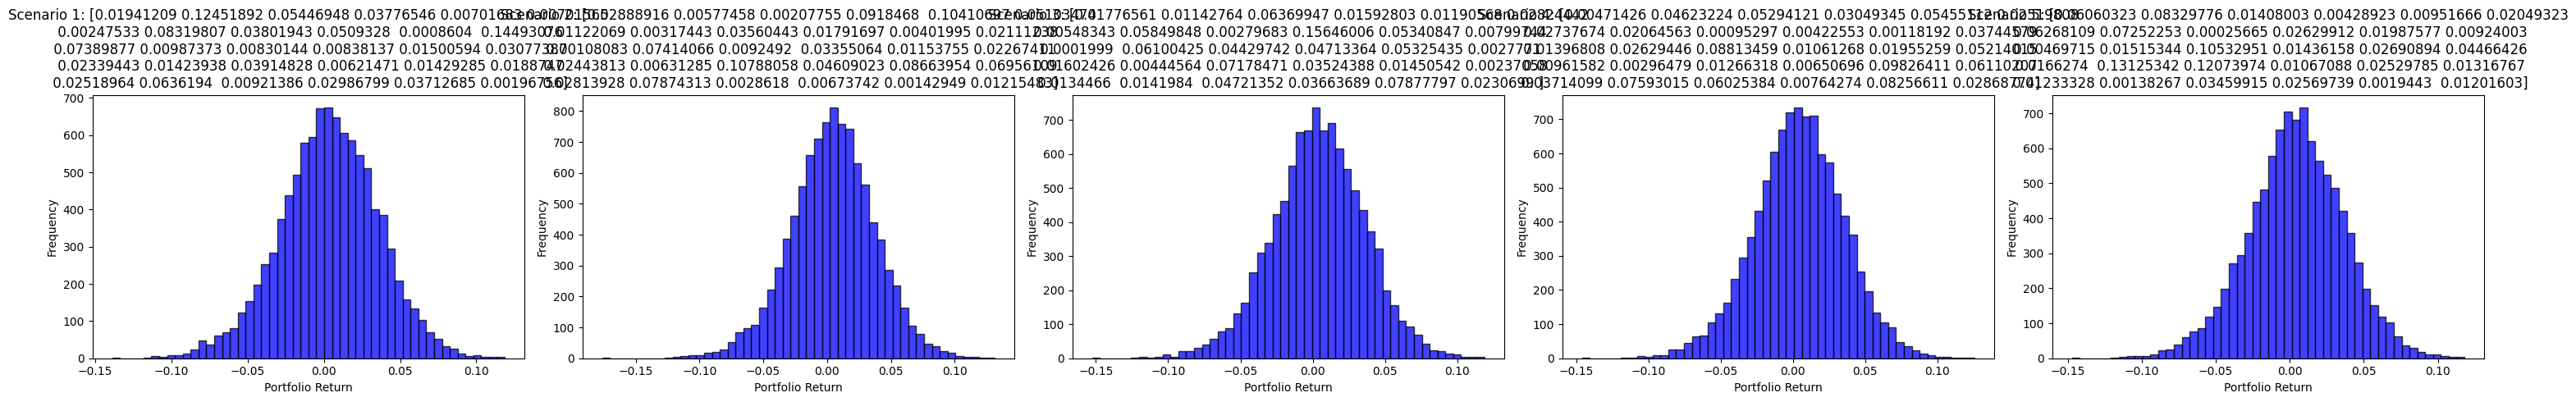

In [19]:
class PortfolioReturnSimulator(BaseEstimator, TransformerMixin):
    """
    Simulates portfolio returns using KDE for asset returns and a correlation matrix,
    with weight scenarios provided externally.
    """
    def __init__(self, correlation_matrix, kde_estimator, num_simulations):
        """
        Args:
            correlation_matrix (np.ndarray): Correlation matrix for the assets.
            kde_estimator (EnhancedTimeSeriesKDE): Object containing KDE functions for asset distributions.
            num_simulations (int): Number of Monte Carlo simulations to run.
        """
        self.correlation_matrix = correlation_matrix
        self.kde_estimator = kde_estimator
        self.num_simulations = num_simulations

    def fit(self, X=None, y=None):
        return self

    def transform(self, weights):
        """
        Simulates portfolio returns given the correlation matrix, KDE-sampled asset returns, 
        and externally provided weight scenarios.

        Args:
            weights (np.ndarray): Each row corresponds to a weight scenario.

        Returns:
            np.ndarray: Simulated portfolio returns for all weight scenarios.
        """
        num_assets = len(self.kde_estimator.data.columns)

        # Generate simulated returns for each asset using KDE
        simulated_returns = np.zeros((self.num_simulations, num_assets))
        for i, stock in enumerate(self.kde_estimator.data.columns):
            simulated_returns[:, i] = self.kde_estimator.sample_from_kde(stock, self.num_simulations)
        
        # Introduce correlation using Cholesky decomposition
        chol_matrix = np.linalg.cholesky(self.correlation_matrix)
        correlated_returns = simulated_returns @ chol_matrix.T

        # Calculate portfolio returns for each weight scenario
        portfolio_scenarios = []
        for scenario_weights in weights:
            portfolio_returns = np.dot(correlated_returns, scenario_weights)
            portfolio_scenarios.append(portfolio_returns)
        
        return np.array(portfolio_scenarios)


def plot_simulated_portfolio_distributions(simulated_returns, weight_scenarios):
    """
    Plots the simulated portfolio return distributions for each weight scenario.

    Args:
        simulated_returns (np.ndarray): Simulated portfolio returns for all scenarios.
        weight_scenarios (list): List of weight allocations for each scenario.
    """
    num_scenarios = len(weight_scenarios)
    fig, axes = plt.subplots(nrows=1, ncols=num_scenarios, figsize=(6 * num_scenarios, 5), squeeze=False)
    axes = axes.flatten()

    for i, portfolio_returns in enumerate(simulated_returns):
        ax = axes[i]
        ax.hist(portfolio_returns, bins=50, alpha=0.75, color='blue', edgecolor='black')
        ax.set_title(f"Scenario {i + 1}: {weight_scenarios[i]}")
        ax.set_xlabel("Portfolio Return")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


# Example Usage
if __name__ == "__main__":

    # Simulate portfolio returns
    simulator = PortfolioReturnSimulator(correlation_matrix, kde_estimator, num_simulations)
    simulated_returns = simulator.transform(weight_scenarios)

    # Plot the simulated distributions
    plot_simulated_portfolio_distributions(simulated_returns, weight_scenarios)
